# Project for DSP2 
#### Olzhas Uikas

### Task 2 - Clustering with any dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer, r2_score

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Task 2:
1. Select any dataset that will suit for clustering
2. Observe your data
3. Apply some data preparation
4. Apply clustering model
5. Visualise your obtained clusters

#### Select any dataset that will suit for clustering

In [2]:
dataset_ = pd.read_csv('OnlineRetail.csv')

#### Observe your data

In [3]:
dataset_.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
dataset_.shape

(541909, 8)

In [5]:
dataset_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
dataset_[dataset_.columns].isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
dataset_.dropna(inplace=True)

In [8]:
print(dataset_[dataset_.columns].isnull().sum())
print(f"Shape: {dataset_.shape}")

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Shape: (406829, 8)


In [9]:
dataset = dataset_.copy()
dataset.drop(['StockCode', 'Description', 'Country'], axis = 1, inplace = True)

In [10]:
dataset["AMOUNT"] = dataset.UnitPrice * dataset.Quantity

#### Apply some data preparation

In [11]:
dataset['CustomerID'] = dataset.CustomerID.astype(int)

In [12]:
dataset.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,AMOUNT
0,536365,6,01-12-2010 08:26,2.55,17850,15.30
1,536365,6,01-12-2010 08:26,3.39,17850,20.34
2,536365,8,01-12-2010 08:26,2.75,17850,22.00
3,536365,6,01-12-2010 08:26,3.39,17850,20.34
4,536365,6,01-12-2010 08:26,3.39,17850,20.34


* monetary - total amount of transactions 

In [13]:
dataset_monetory = dataset.groupby('CustomerID').AMOUNT.sum().to_frame()
dataset_monetory.rename(columns = {'AMOUNT':'MONETORY'}, inplace = True)
dataset_monetory.head()

,MONETORY
CustomerID,
12346,0.00
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


* frequency - number of tracsactions

In [14]:
dataset_frequency = dataset.groupby('CustomerID').InvoiceDate.count().to_frame()
dataset_frequency.rename(columns = {'InvoiceDate':'FREQUENCY'}, inplace = True)
dataset_frequency.head()

,FREQUENCY
CustomerID,
12346,2
12347,182
12348,31
12349,73
12350,17


* recency - number of days since the last purchase

In [15]:
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'], format='%d-%m-%Y %H:%M')
recent = dataset['InvoiceDate'].max()
dataset_recency_ = dataset.copy()
dataset_recency_['RecentDiff'] = recent - dataset['InvoiceDate']

In [16]:
dataset_recency = dataset_recency_.groupby('CustomerID').RecentDiff.min().dt.days.to_frame()
dataset_recency.rename(columns = {'RecentDiff':'RECENCY'}, inplace = True)
dataset_recency.head()

,RECENCY
CustomerID,
12346,325
12347,1
12348,74
12349,18
12350,309


In [17]:
dataset_rfm_ = pd.concat([dataset_monetory, dataset_frequency, dataset_recency], axis=1)

In [18]:
dataset_rfm_

,MONETORY,FREQUENCY,RECENCY
CustomerID,,,
12346,0.00,2,325
12347,4310.00,182,1
12348,1797.24,31,74
12349,1757.55,73,18
12350,334.40,17,309
...,...,...,...
18280,180.60,10,277
18281,80.82,7,180
18282,176.60,13,7


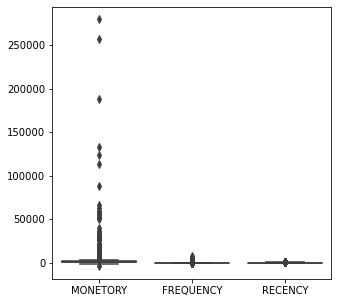

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=dataset_rfm_, ax=ax)
plt.show()

In [20]:
# Remove Outliers
rfm = dataset_rfm_.copy()

Q1 = rfm.MONETORY.quantile(0.05)
Q3 = rfm.MONETORY.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.MONETORY >= Q1 - 1.5*IQR) & (rfm.MONETORY <= Q3 + 1.5*IQR)]

Q1 = rfm.RECENCY.quantile(0.05)
Q3 = rfm.RECENCY.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.RECENCY >= Q1 - 1.5*IQR) & (rfm.RECENCY <= Q3 + 1.5*IQR)]

Q1 = rfm.FREQUENCY.quantile(0.05)
Q3 = rfm.FREQUENCY.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.FREQUENCY >= Q1 - 1.5*IQR) & (rfm.FREQUENCY <= Q3 + 1.5*IQR)]
dataset_rfm = rfm

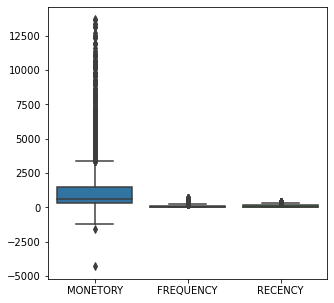

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=dataset_rfm, ax=ax)
plt.show()

#### Apply clustering model

* k-means

In [22]:
# pip install yellowbrick

In [23]:
from yellowbrick.cluster import KElbowVisualizer

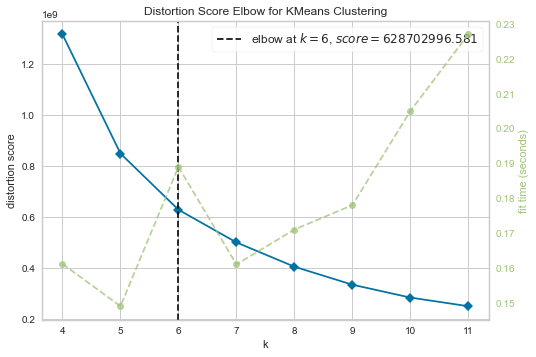

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
# Elbow Method
model_kmeans_ = KMeans(random_state = 2022)
cluster_kMeans = KElbowVisualizer(model_kmeans_, k=(4,12)).fit(dataset_rfm)
cluster_kMeans.show()

In [25]:
# final model with k=6
model_kmeans = KMeans(n_clusters=6, random_state = 2022)
model_kmeans.fit(dataset_rfm)

KMeans(n_clusters=6, random_state=2022)

In [26]:
model_kmeans.labels_

array([2, 5, 0, ..., 2, 2, 0])

In [27]:
dataset_rfm['CLUSTER'] = model_kmeans.labels_
dataset_rfm.head()

,MONETORY,FREQUENCY,RECENCY,CLUSTER
CustomerID,,,,
12346,0.00,2,325,2
12347,4310.00,182,1,5
12348,1797.24,31,74,0
12349,1757.55,73,18,0
12350,334.40,17,309,2


* Hierarchical Clustering

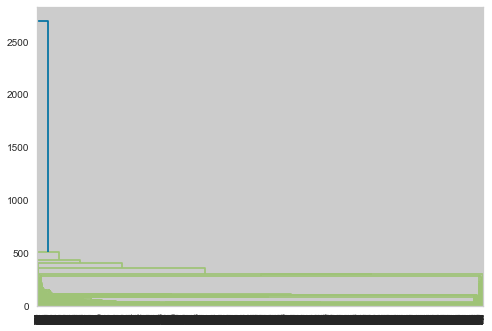

In [35]:
# Single linkage: 
single_linkage = linkage(dataset_rfm, method="single", metric='euclidean')
dendrogram(single_linkage)
plt.show()

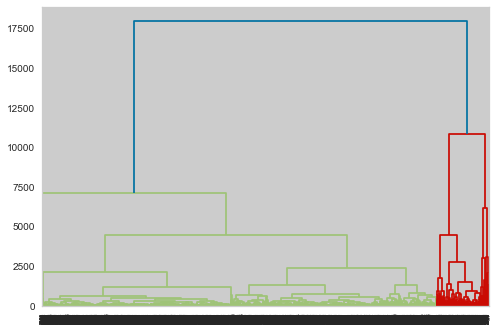

In [36]:
# Complete linkage
complete_linkage = linkage(dataset_rfm, method="complete", metric='euclidean')
dendrogram(complete_linkage)
plt.show()

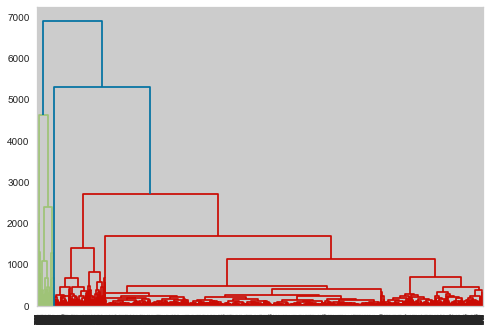

In [37]:
# Average linkage
average_linkage = linkage(dataset_rfm, method="average", metric='euclidean')
dendrogram(average_linkage)
plt.show()

In [62]:
cluster_labels = cut_tree(complete_linkage, n_clusters=6).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [63]:
dataset_rfm['CLUSTER_LABEL'] = cluster_labels
rfm.head()

,MONETORY,FREQUENCY,RECENCY,CLUSTER,Cluster_Labels,CLUSTER_LABEL
CustomerID,,,,,,
12346,0.00,2,325,2,0,0
12347,4310.00,182,1,5,0,1
12348,1797.24,31,74,0,0,0
12349,1757.55,73,18,0,0,0
12350,334.40,17,309,2,0,0


#### Visualise your obtained clusters

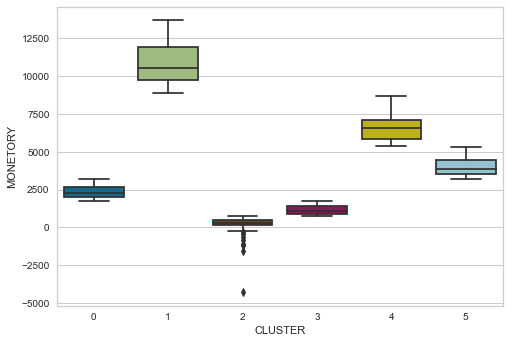

In [28]:
sns.boxplot(x='CLUSTER', y='MONETORY', data=dataset_rfm)
plt.show()

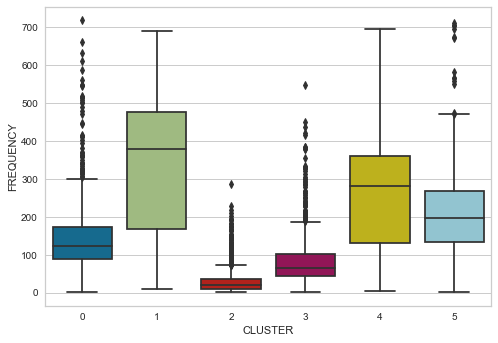

In [29]:
sns.boxplot(x='CLUSTER', y='FREQUENCY', data=dataset_rfm)
plt.show()

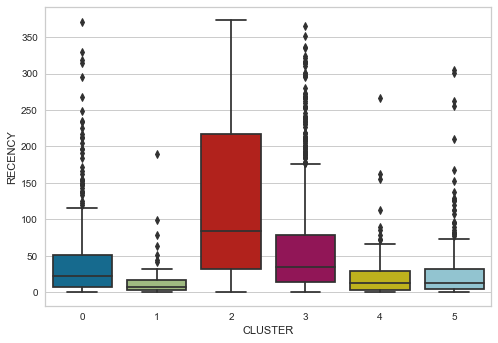

In [30]:
sns.boxplot(x='CLUSTER', y='RECENCY', data=dataset_rfm)
plt.show()

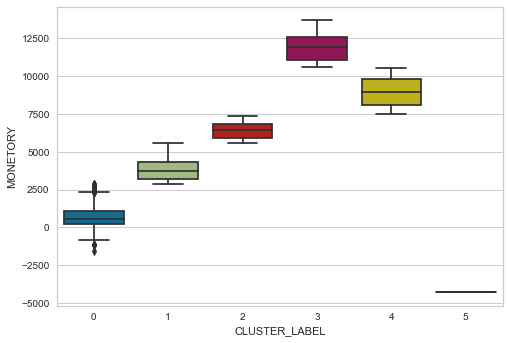

In [64]:
sns.boxplot(x='CLUSTER_LABEL', y='MONETORY', data=dataset_rfm)
plt.show()

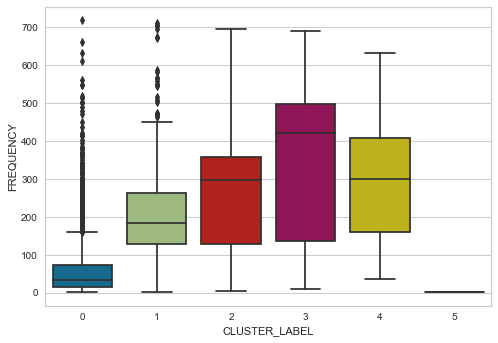

In [65]:
sns.boxplot(x='CLUSTER_LABEL', y='FREQUENCY', data=dataset_rfm)
plt.show()

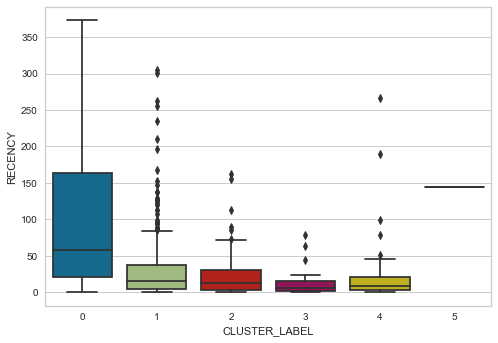

In [66]:
sns.boxplot(x='CLUSTER_LABEL', y='RECENCY', data=dataset_rfm)
plt.show()

K-Means Clustering with 6 Cluster

* Customers with Cluster 1 are the customers with high amount of transactions as compared to other customers.
* Customers with Cluster 2 most of them are not recent customers
* Customers with Cluster 2 are the customers with low amount of transactions.

Hierarchical Clustering with 6 Cluster Labels

* Customers with Cluster Label 3 are the recent customers with high amount of transactions
* Customers with Cluster Label 0 are not the recent customers as compared to other customers.